# Peer-graded Assignment: Описательный анализ данных

Часто при работе с пользовательскими данными приходится сталкиваться с тем, что данные предоставляются для работы без описания. При этом не известно, что содержательно представляют собой те или иные признаки, а известны лишь их типы: числовые, категориальные, номинальные переменные. Такие ситуации - не редкость при работе с «чувствительными» данными, например, в сфере банковской аналитики, HR-аналитики, сфере телекоммуникаций, страхования, здравоохранения, недвижимости или ритейла. Тем не менее, с такими данным нужно уметь работать, и нужно уметь проводить на них классические этапы анализа, в частности описательный анализ данных и визуализацию. Именно этим мы займемся на первой неделе.


В этом задании мы потренируемся делать описательный анализ и визуализацию так называемых «закрытых» данных - данных, которые предоставляются для анализа и построения моделей без описания. Выборка, с которой мы будем работать прилагается.

* Метки классов (здесь `1` соответствует классу `отток`, `-1` - классу `не отток`) – `orange_small_churn_labels.train`
* Данные (предоставлены без описания, однако известно, что первые 190 переменных являются числовыми, а оставшиеся 40 - категориальными) – `orange_small_churn_data.train`

Скачайте эти файлы [на странице задания](https://www.coursera.org/learn/data-analysis-project/peer/roSOe/opisatiel-nyi-analiz-dannykh) и переходите к выполнению задачи! Результатом выполнения задания является jupyter notebook. Перед отправкой результата убедитесь, что вы выполнили все пункты из задания и это можно понять из вашего notebook'а. Проверьте, что код написан понятно и аккуратно - это поможет вашим сокурсником лучше понять, что вы сделали, и оценить вашу работу.

## Инструкции

1\. Загрузите данные `orange_small_churn_data.train` и `orange_small_churn_labels.train`

In [7]:
import pandas as pd
import numpy as np
import operator   
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
Y = pd.read_csv('orange_small_churn_labels.txt')
X = pd.read_csv('orange_small_churn_data.txt')

2\. Рассчитайте доли классов `отток` и `не отток`.

In [2]:
print('Fruction of non-churn: {}%'.format(round(Y.iloc[:,0].value_counts().loc[-1]/float(len(Y.iloc[:,0]))*100, 2)))
print('Fruction of churn: {}%'.format(round(Y.iloc[:,0].value_counts().loc[1]/float(len(Y.iloc[:,0]))*100, 2)))

Fruction of non-churn: 92.56%
Fruction of churn: 7.44%


3\. Рассчитайте корреляции переменных с целевой функцией и проанализируйте полученные данные.

Обратите внимание на то, что целевая функция предсталвляет собой бинарную переменную. Теоретически, это не помешает рассчиать, например, корреляцию Пирсона между непрерывной переменной и целевой функцией, онднако анализиоовать полученные результаты будет сложно, корреляция Пирсона просто не рассчитана на такое применение. Кто уже забыл, как действовать в такой ситуации - вспоминить можно вот здесь: https://www.coursera.org/teach/stats-for-data-analysis/content/edit/lecture/prX3S/video-subtitles 

<font color='green'>Сначала расчитаем критерий Крамера для категориальных признаков </font>

In [3]:
# it is simple realization of Cramer's test from Stackoverflow
from scipy import stats as ss
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


In [4]:
# take only categorical attributes
X_cat = X.iloc[:, 190:]
X_cat_corrs = {}
for col in X_cat:
    # merge column of X_cat and Y, excuding all NaN objects
    temp = pd.merge(pd.DataFrame(X_cat.loc[:,col]).dropna(), Y, left_index=True, right_index=True)
    # make confusion matrix of this attribute and target 
    confusion_matrix = pd.crosstab(temp.iloc[:,0], temp.iloc[:,1])
    # check if it is appropriate to use Cramer's test
    count = 0.
    for i in confusion_matrix.columns:
        for j in confusion_matrix.index:
            if (confusion_matrix.loc[j,i]<5):
                count +=1
    if (confusion_matrix.shape[0]!=0 and confusion_matrix.shape[1]!=0 and temp.shape[0]>40):
        if (count/(confusion_matrix.shape[0]*confusion_matrix.shape[1])<0.2):
            # count coefficient
            X_cat_corrs[col] = cramers_corrected_stat(confusion_matrix)
       

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in longlong_scalars
  from ipykernel import kernelapp as app


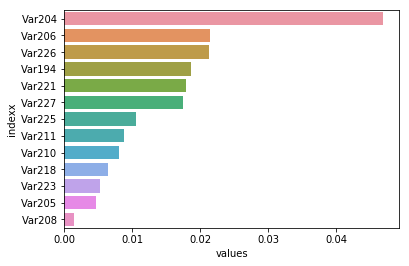

In [8]:
X_cat_corrs_sorted = sorted(X_cat_corrs.items(), key=operator.itemgetter(1), reverse=True)

indexx, values=[], []
for i in X_cat_corrs_sorted: 
   indexx.append(i[0])
   values.append(i[1])
X_cat_bar = pd.DataFrame(index=range(len(indexx)))
X_cat_bar['indexx'] = indexx
X_cat_bar['values'] = values
sns.barplot(x='values', y='indexx', data=X_cat_bar.iloc[:13,:])

<font color='green'>Затем разницу матожиданий разных классов у числовых переменных. Чтобы в
итоге была возможность сравнивать полученные значения, проведем стандартизацию</font>

In [9]:
# take only numerical attributes
X_num = X.iloc[:, :189]
# fill NaN with mean of each column
for col in X_num.columns:
    mean = X_num.loc[:,col].mean()
    X_num.loc[:,col].fillna(mean, inplace=True)
# few columns were absolutely empty
X_num.dropna(axis=1, inplace=True)
X_num.shape

(40000, 173)

In [10]:
# standartize data to make our coefficient comparable
from sklearn.preprocessing import StandardScaler
X_num_scaled = StandardScaler().fit_transform(X_num)
X_num = pd.DataFrame(data=X_num_scaled, index=X_num.index, columns=X_num.columns)

In [12]:
X_num_corrs = {}
data = X.copy()
data.loc[:,'y'] = Y.iloc[:,0]
X_num.loc[:,'y'] = Y.iloc[:,0]

# count mean of values where y==1 minus mean of values where y==-1
for col in X_num.columns[:-1]:
    X_churn = X_num.loc[:,col][X_num.loc[:,'y']==1]
    X_non_churn = X_num.loc[:,col][X_num.loc[:,'y']==-1]
    
    X_num_corrs[col]=abs(sum(X_churn)/len(data[data.loc[:,'y']==1].loc[:,col].dropna())-
                         sum(X_non_churn)/len(data[data.loc[:,'y']==-1].loc[:,col].dropna()))
    
   

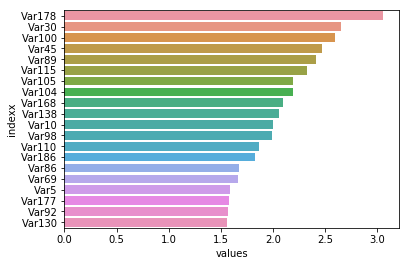

In [13]:
X_num_corrs_sorted = sorted(X_num_corrs.items(), key=operator.itemgetter(1), reverse=True)

indexx, values=[], []
for i in X_num_corrs_sorted: 
   indexx.append(i[0])
   values.append(i[1])
X_num_bar = pd.DataFrame(index=range(len(indexx)))
X_num_bar['indexx'] = indexx
X_num_bar['values'] = values
# X_num_bar.iloc[:20, :].plot.bar()
sns.barplot(x='values', y='indexx', data=X_num_bar.iloc[:20,:])

<font color='green'>Дальше до четвертого пункта не обязательно просматривать. Но кому интересно хотел бы узнать ваше мнение. Дело в том, что модель, будь то lightgbm или xgboost, обученная на данных, имеет возможность вывести feature_importance, и мне кажется это более удобным и надежным способом определить значимость признака с учетом других признаков. Что вы об этом думаете? </font>

In [14]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

# we already have standartized X_num data, prepare X_cat
le = LabelEncoder()
data_lgb = X_num.copy()
for col in X.iloc[:,190:].columns:
    data_lgb.loc[:,col] = le.fit_transform(X.loc[:,col].fillna(-1))

# load data in model
params = {
    'objective':'regression',
    'metric':'rmse',
    'nthread':4,
    'learning_rate':0.08,
    'num_leaves':80,
    'colsample_bytree':0.9,
    'subsample':0.8,
    'max_depth':5,
    'verbose':-1
}
train = lgb.Dataset(X_num.drop('y', axis=1), X_num.loc[:,'y'])
clf = lgb.train(params, train, 150)

feature_importance = {}
for idx,i in enumerate(clf.feature_importance()):
    feature_importance[X_num.columns[idx]] = i
    

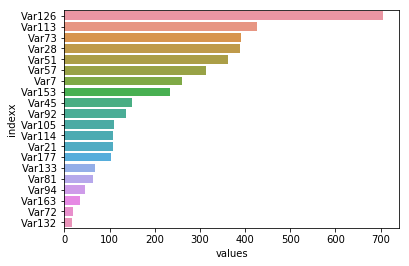

In [15]:
X_num_lgb_sorted = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse=True)

indexx, values=[], []
for i in X_num_lgb_sorted: 
   indexx.append(i[0])
   values.append(i[1])
X_num_bar = pd.DataFrame(index=range(len(indexx)))
X_num_bar['indexx'] = indexx
X_num_bar['values'] = values
# X_num_bar.iloc[:20, :].plot.bar()
sns.barplot(x='values', y='indexx', data=X_num_bar.iloc[:20,:])

<font color='green'>хотя распределения в разрезе классов из следующего пункта уже не показывают существенного различия в отличии от изначального способа расчета корреляции признаков. Тут я обучал только на числовых признаках, а если обучать классификатор на всех признаках, вместе с категориальными, то значимость числовых сводится к нулю. Видимо простая корреляция в данном случае более уместна</font> 

4\. Визуализируйте данные: рассмотрите топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией. Для этих переменных постройте:
* Распределения в разрезе классов
* Отобразите объекты в координатах пар признаков

<font color='green'>Распределения в разрезе классов</font>

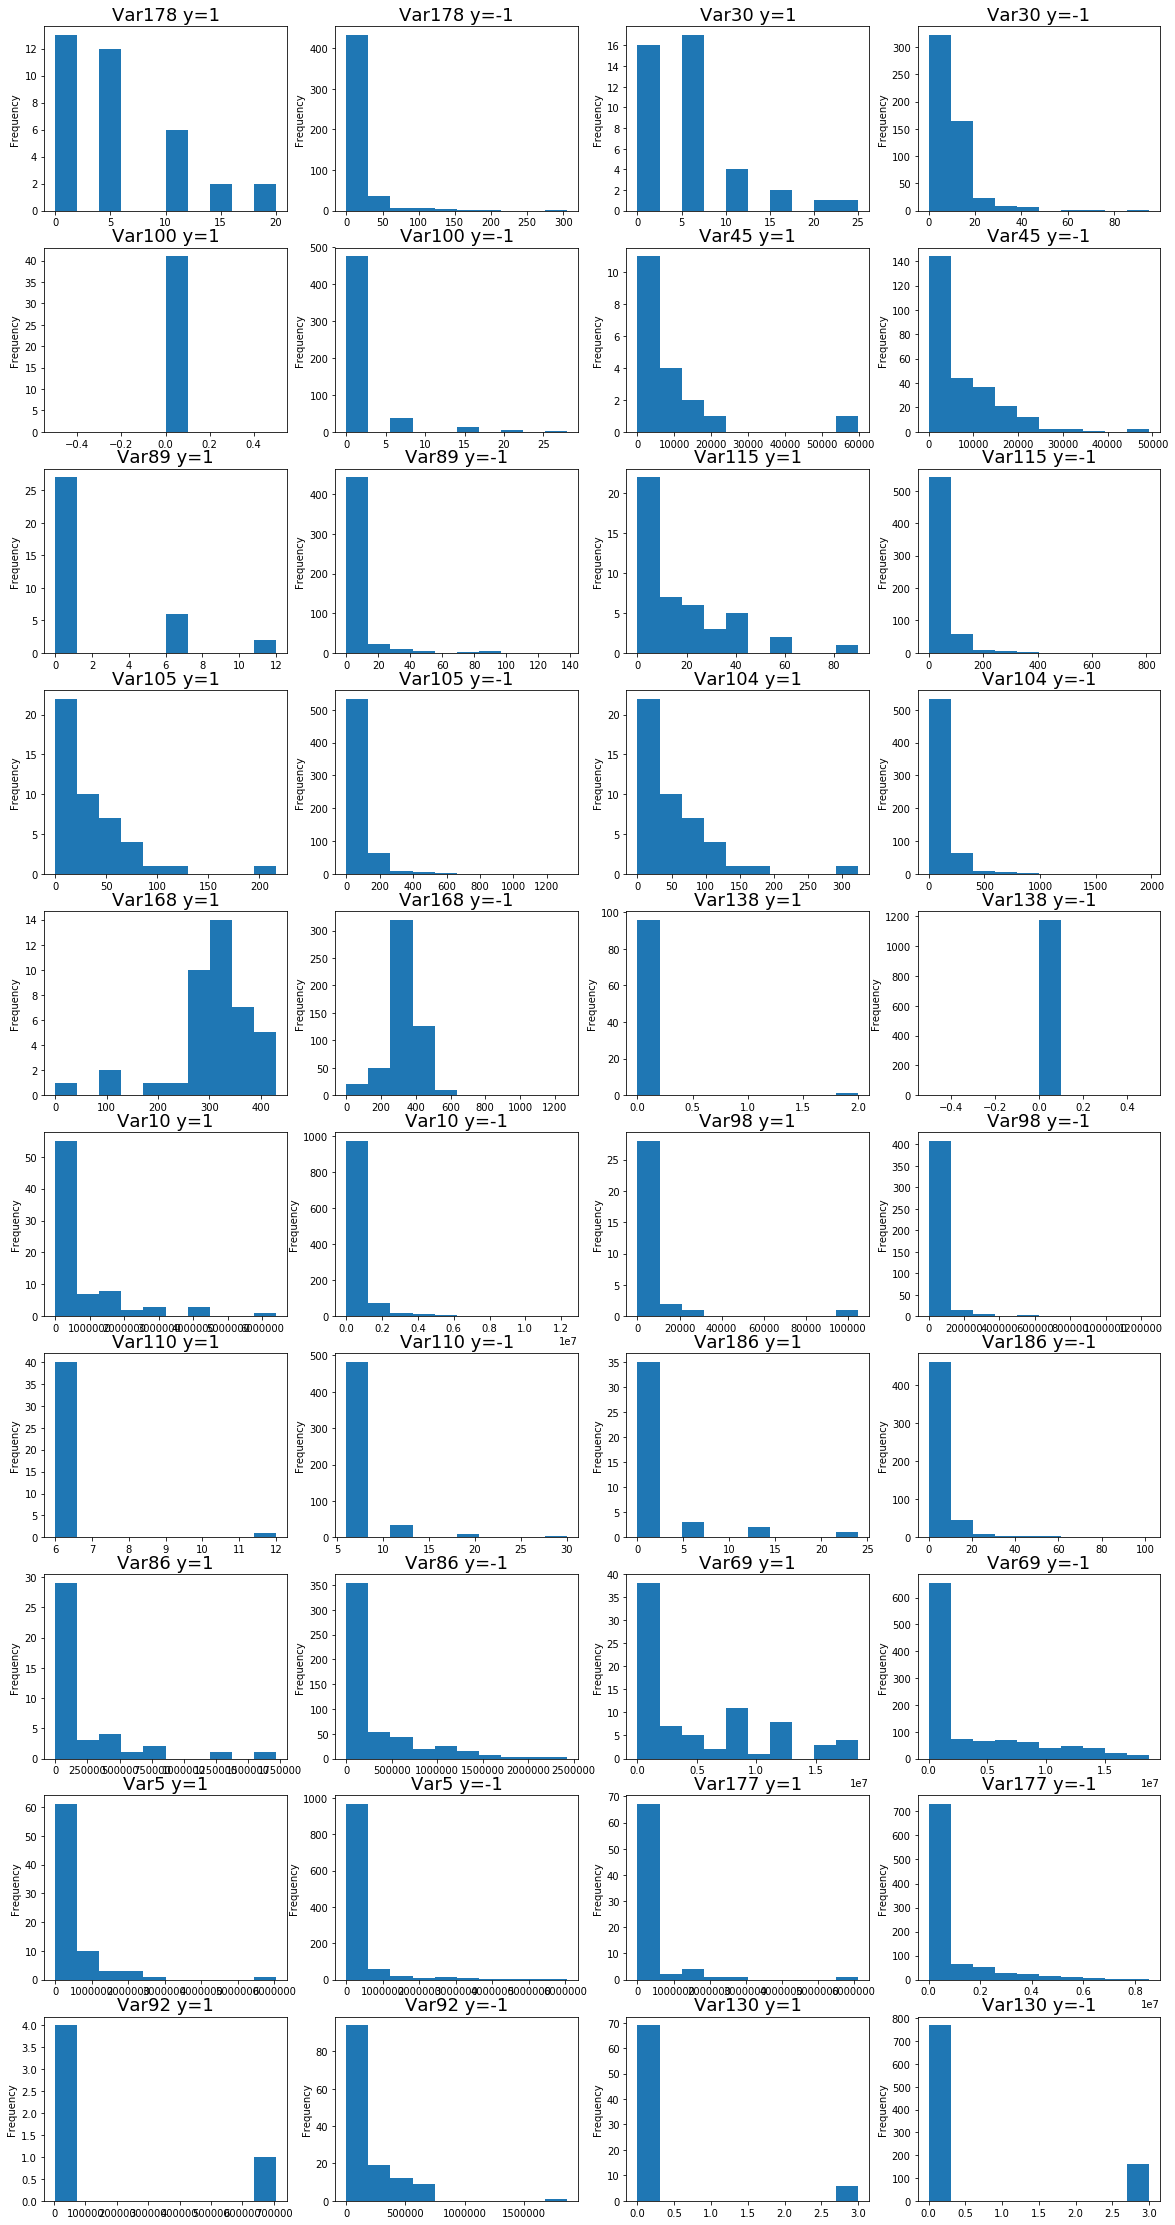

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

top_20 = []
fig, axarr = plt.subplots(10, 4, figsize=(20, 40))
for idx,tup in enumerate(X_num_corrs_sorted[:20]):
    axarr[2*idx/4][2*idx%4].set_title(tup[0]+' y=1', fontsize=18)
    data[data.iloc[:,-1]==1].loc[:,tup[0]].plot.hist(ax=axarr[2*idx/4][2*idx%4])
    axarr[2*idx/4][2*idx%4+1].set_title(tup[0]+' y=-1', fontsize=18)
    data[data.iloc[:,-1]==-1].loc[:,tup[0]].plot.hist(ax=axarr[2*idx/4][2*idx%4+1])
    top_20.append(tup[0])

<font color='green'>Плотности распределения по классам</font>

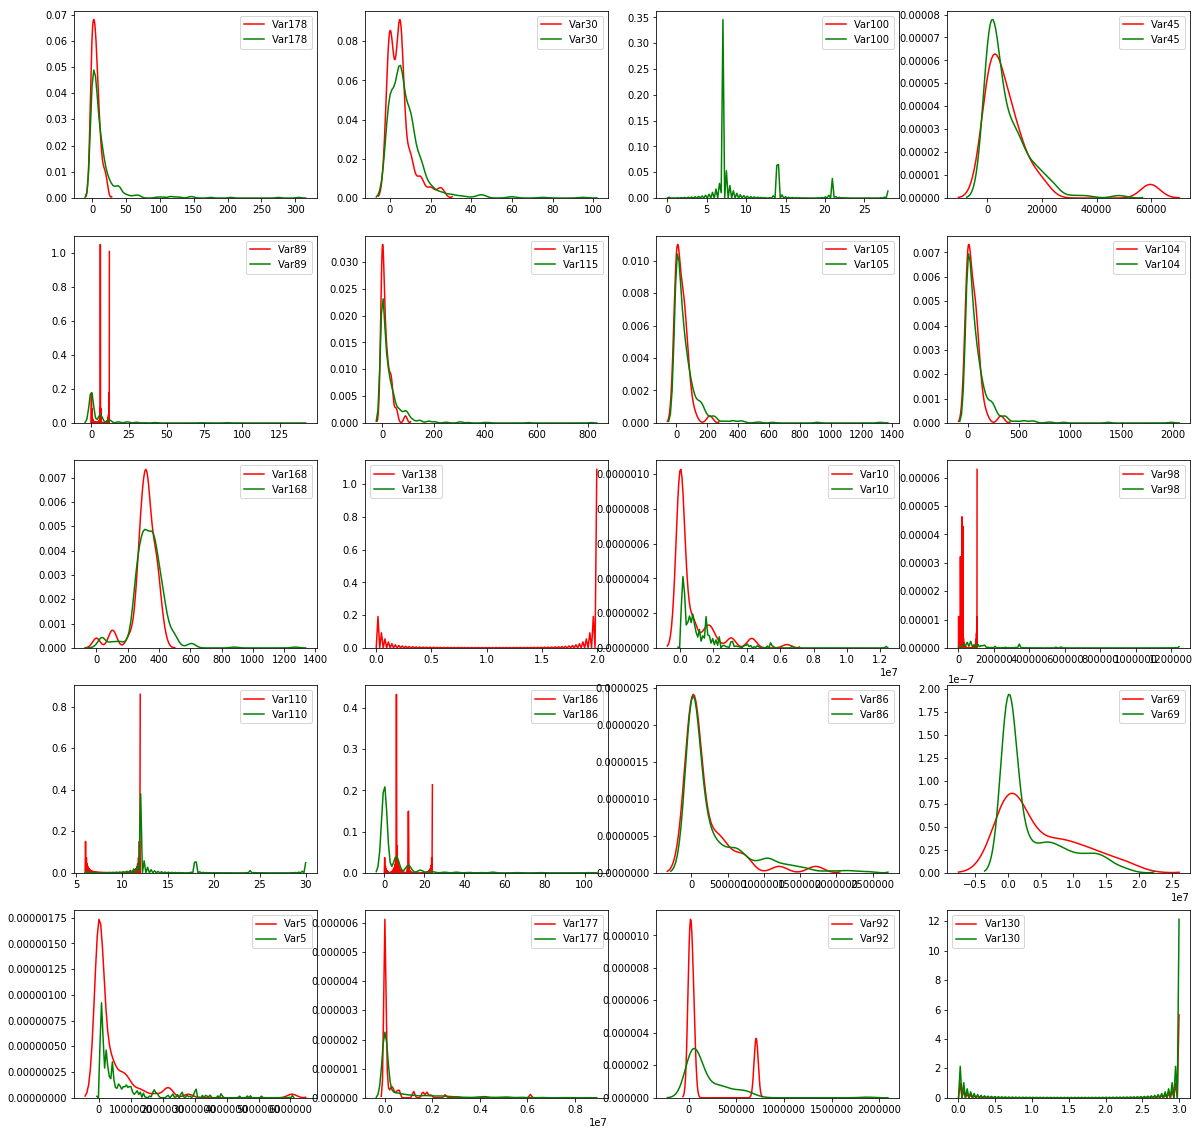

In [39]:
fig3, axarr3 = plt.subplots(5,4,figsize=(20,20))
for idx,col in enumerate(top_20):
    sns.kdeplot(data[data.y==1].loc[:,col],ax=axarr3[idx/4][idx%4], color='red')
    sns.kdeplot(data[data.y==-1].loc[:,col],ax=axarr3[idx/4][idx%4], color='green')    

<font color='green'>Отображаю объекты в координатах пар признаков, sns.pairplot ведет себя некорректно при наличии NaN значений, а заполнение таких значений средним или константой, как мне кажется, сильно исказит графики. Поэтому я сделал в ручную, удаляя NaN объекты в каждой паре отдельно и использовал линейную регрессию, чтобы сравнить распределения классов на каждом графике, красный:y==1, синий:y==-1</font>

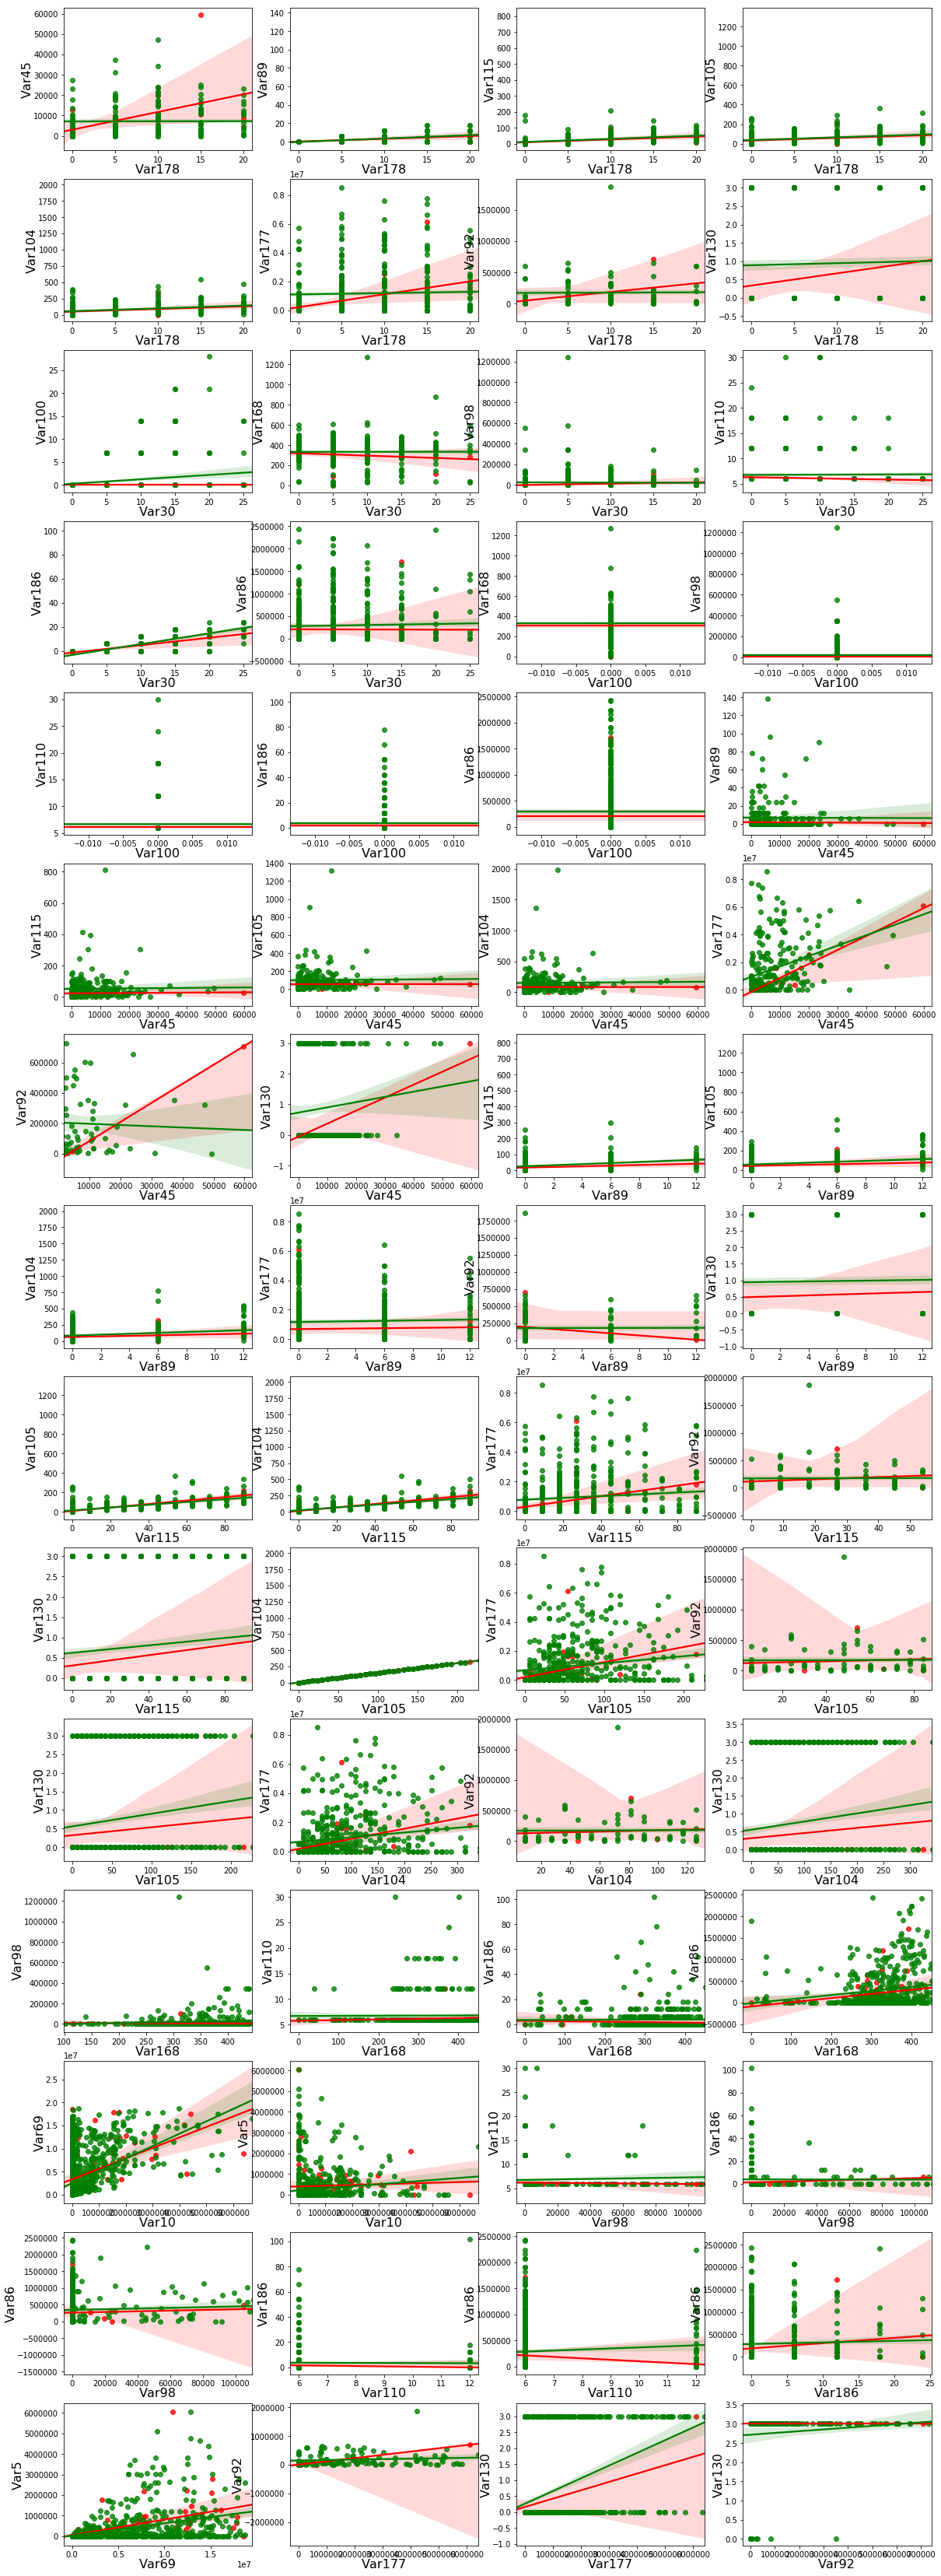

In [17]:
import seaborn as sns
from itertools import combinations
pairs = []
for i in combinations(top_20, 2):
    pairs.append(i)
fig2, axarr2 = plt.subplots(15, 4, figsize=(20, 60))
idx = 0
for pair in pairs:
    temp = data.loc[:,[pair[0],pair[1],'y']].dropna()
    if (temp.shape!=(0,3)):
        axarr2[idx/4][idx%4].set_xlabel(pair[0], fontsize=16, labelpad=0)
        axarr2[idx/4][idx%4].set_ylabel(pair[1], fontsize=16, labelpad=0)

#         temp.plot(x=pair[0], y=pair[1], subplots=True, kind='scatter', ax=axarr2[idx/4][idx%4])
        sns.regplot(x=pair[0], y=pair[1], data=temp[temp.y==1], ax=axarr2[idx/4][idx%4], color='red')
        sns.regplot(x=pair[0], y=pair[1], data=temp[temp.y==-1], ax=axarr2[idx/4][idx%4], color='green')

        idx +=1


5\. Проделайте аналогичные шаги для случайно выбранных 10 числовых признаков.

In [27]:
indexes = list(np.squeeze(np.random.randint(189, size=(1,10))))

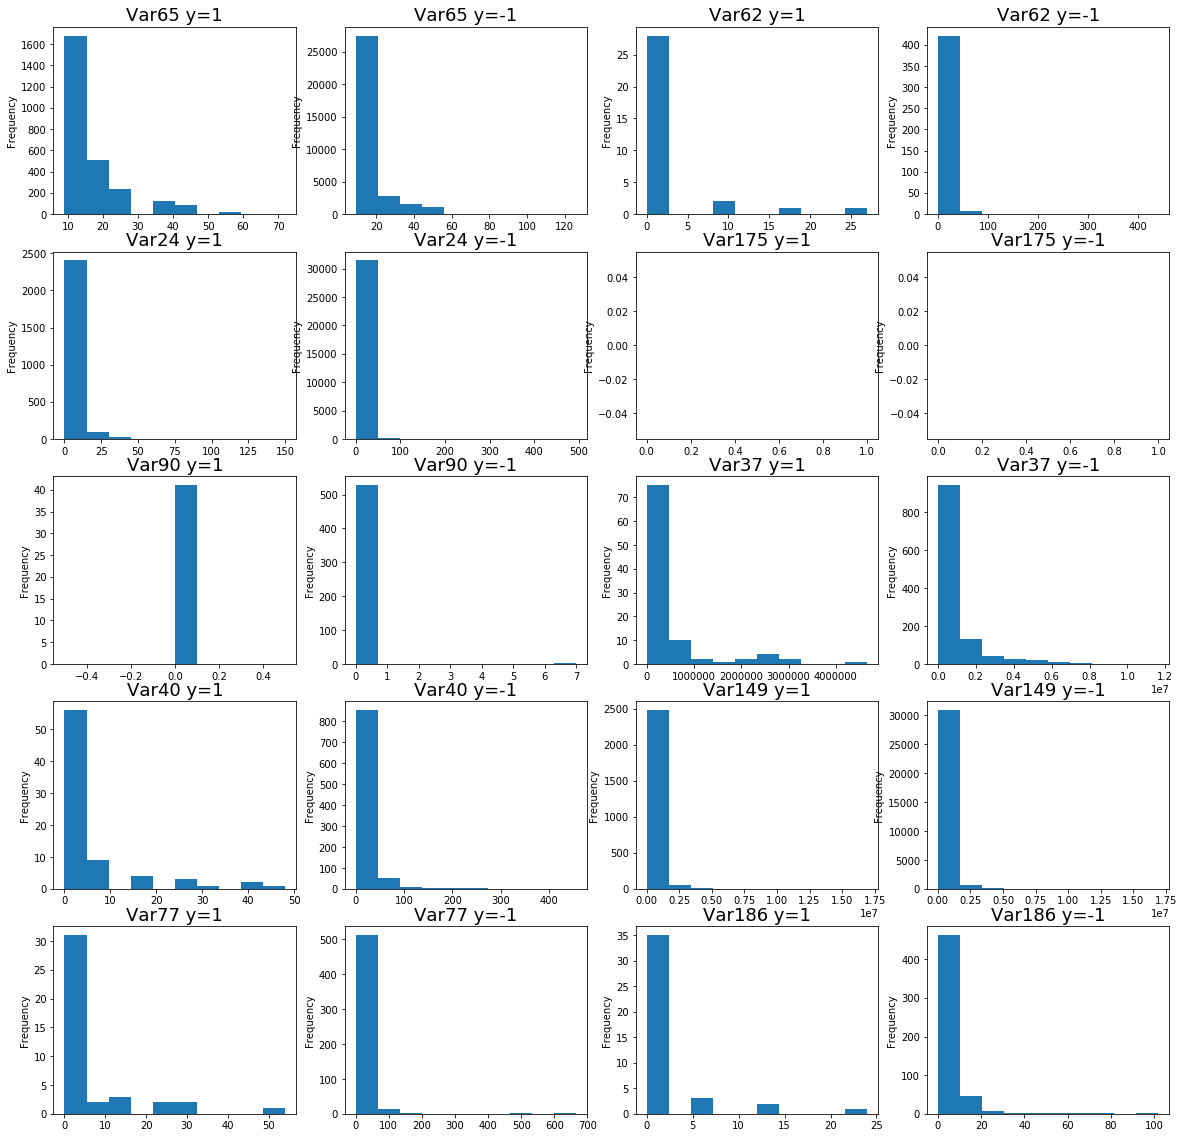

In [19]:
fig, axarr = plt.subplots(5, 4, figsize=(20, 20))

for idx,col in enumerate(X.iloc[:,indexes].columns):
    axarr[2*idx/4][2*idx%4].set_title(col+' y=1', fontsize=18)
    data[data.loc[:,'y']==1].loc[:,col].plot.hist(ax=axarr[2*idx/4][2*idx%4])
    axarr[2*idx/4][2*idx%4+1].set_title(col+' y=-1', fontsize=18)
    data[data.loc[:,'y']==-1].loc[:,col].plot.hist(ax=axarr[2*idx/4][2*idx%4+1])

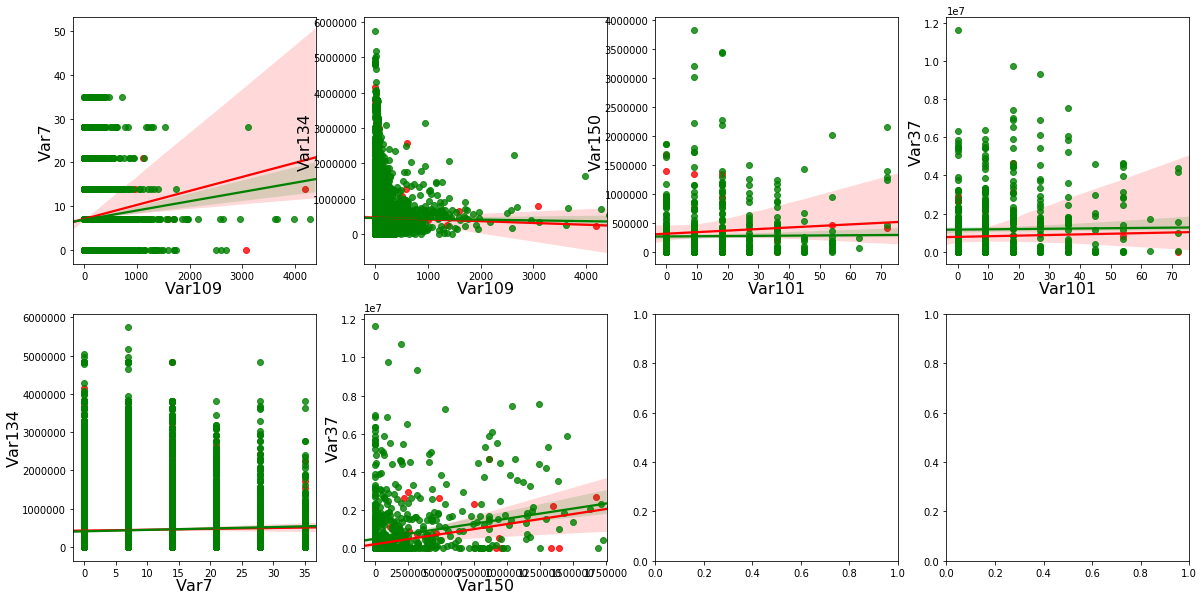

In [28]:
pairs=[]
for i in combinations(indexes, 2):
    pairs.append(i)
fig2, axarr2 = plt.subplots(2, 4, figsize=(20, 10))
idx = 0
for pair in pairs:
    temp = data.iloc[:,[pair[0],pair[1],-1]].dropna()
    if (temp.shape!=(0,3)):
        axarr2[idx/4][idx%4].set_xlabel(X.columns[pair[0]], fontsize=16, labelpad=0)
        axarr2[idx/4][idx%4].set_ylabel(X.columns[pair[1]], fontsize=16, labelpad=0)

#         temp.plot(x=pair[0], y=pair[1], subplots=True, kind='scatter', ax=axarr2[idx/4][idx%4])
        sns.regplot(x=X.columns[pair[0]], y=X.columns[pair[1]], data=temp[temp.y==1], ax=axarr2[idx/4][idx%4], color='red')
        sns.regplot(x=X.columns[pair[0]], y=X.columns[pair[1]], data=temp[temp.y==-1], ax=axarr2[idx/4][idx%4], color='green')

        idx +=1

6\. Проделайте аналогичные шаги для 10 числовых признаков, наименее сильно коррелирующих с целевой переменной.

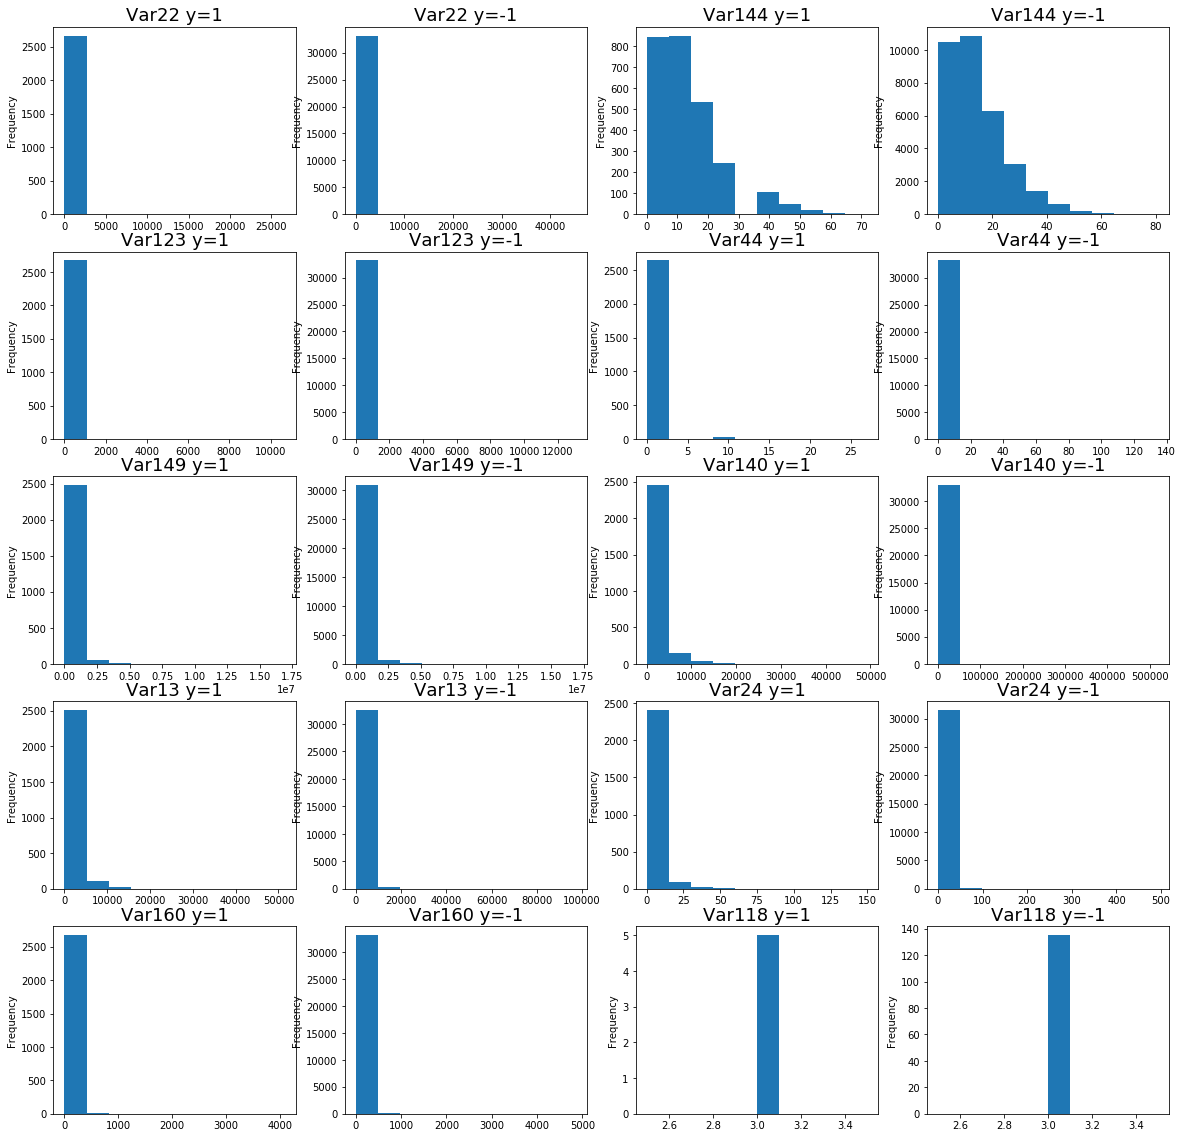

In [22]:
low_10 = []
fig, axarr = plt.subplots(5, 4, figsize=(20, 20))
for idx,tup in enumerate(X_num_corrs_sorted[-10:]):
    axarr[2*idx/4][2*idx%4].set_title(tup[0]+' y=1', fontsize=18)
    data[data.iloc[:,-1]==1].loc[:,tup[0]].plot.hist(ax=axarr[2*idx/4][2*idx%4])
    axarr[2*idx/4][2*idx%4+1].set_title(tup[0]+' y=-1', fontsize=18)
    data[data.iloc[:,-1]==-1].loc[:,tup[0]].plot.hist(ax=axarr[2*idx/4][2*idx%4+1])
    low_10.append(tup[0])

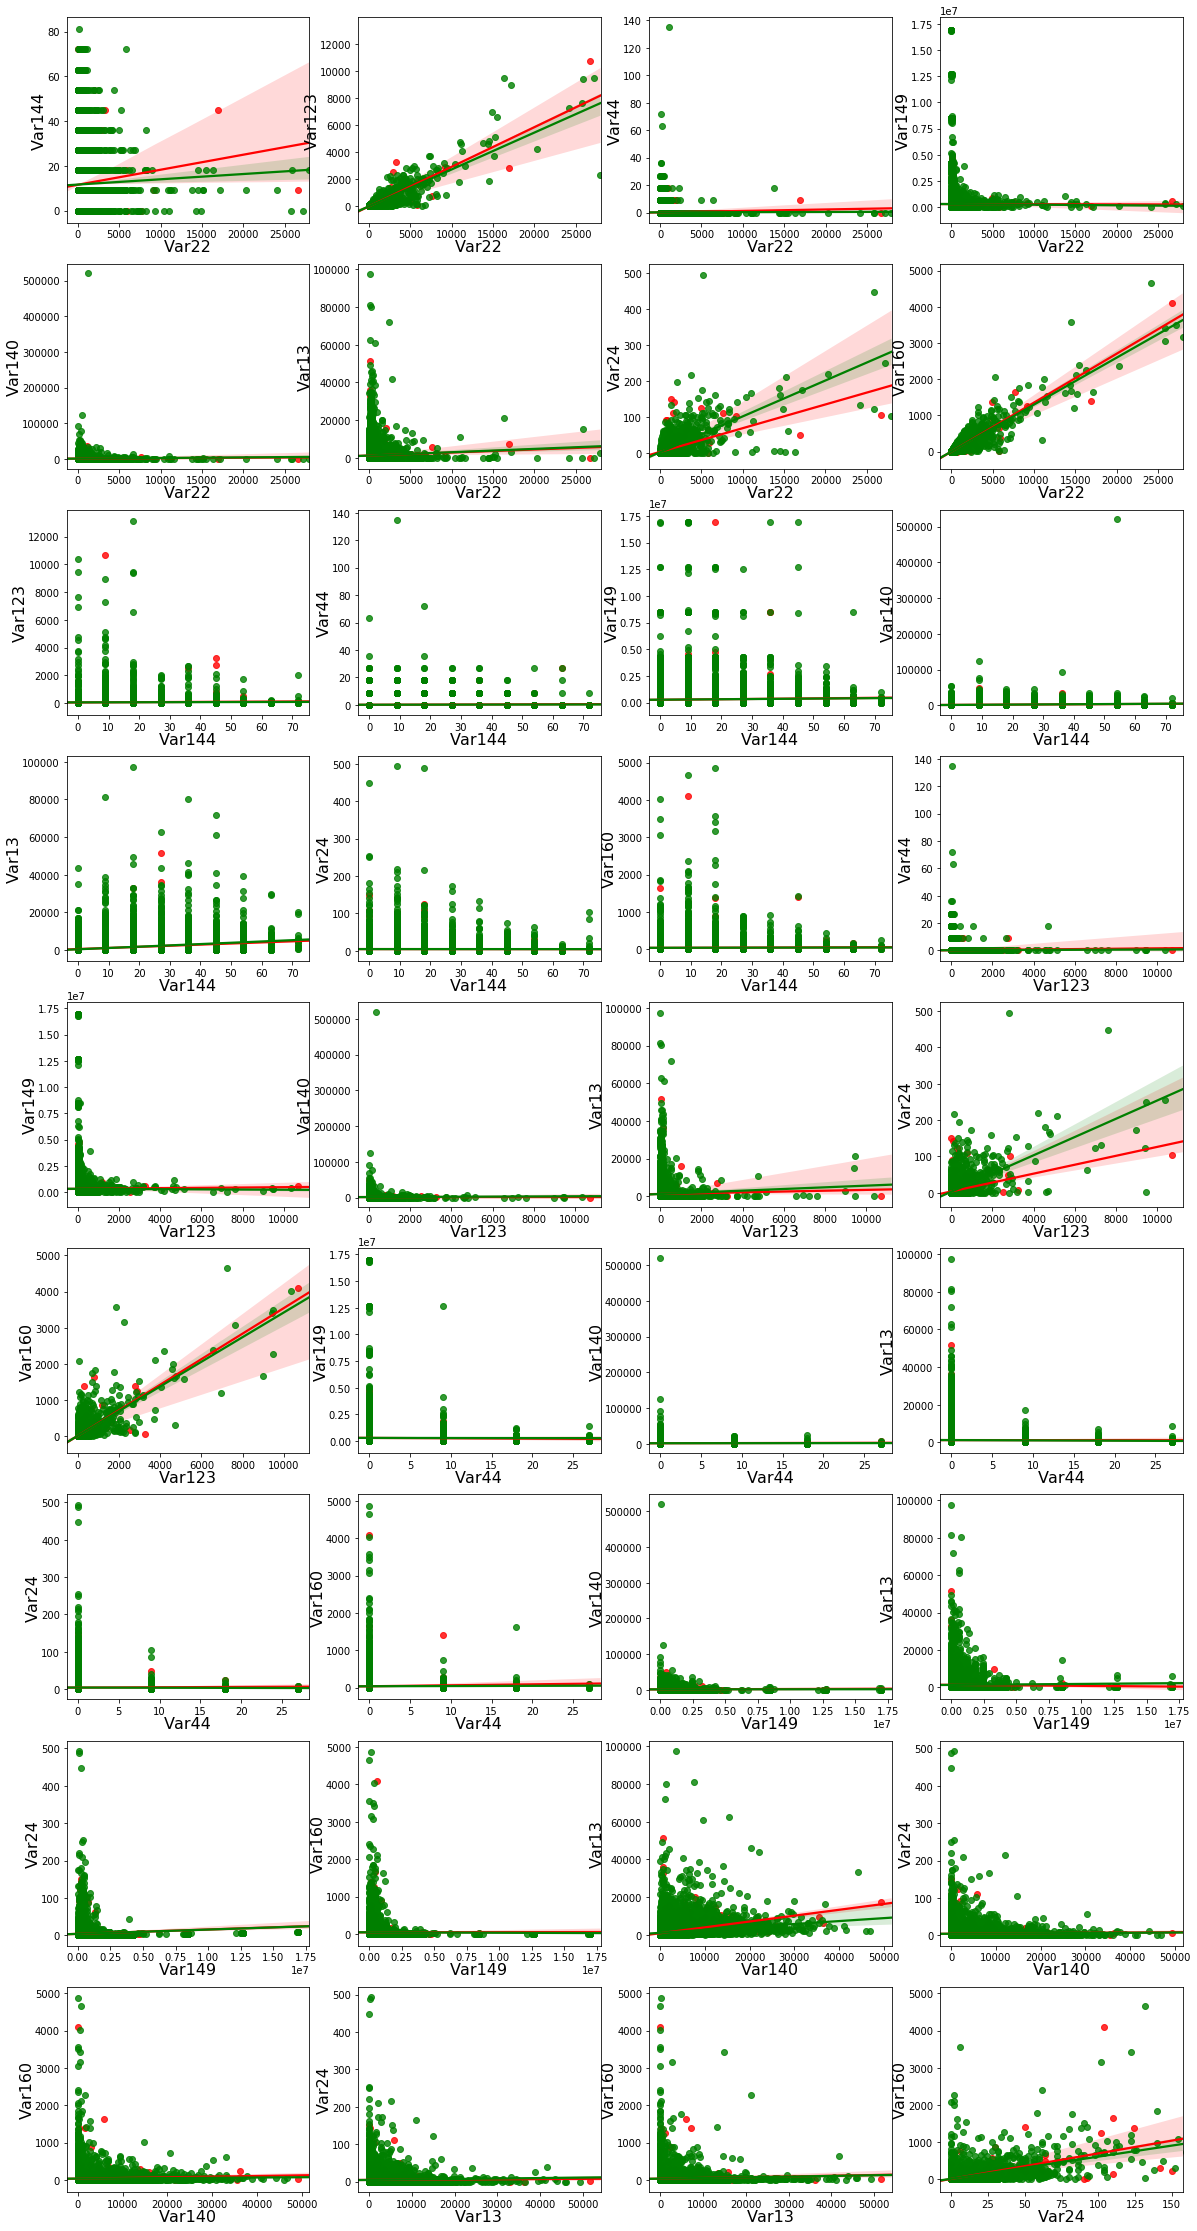

In [23]:
pairs = []
for i in combinations(low_10, 2):
    pairs.append(i)
fig2, axarr2 = plt.subplots(9, 4, figsize=(20, 40))
idx = 0
for pair in pairs:
    temp = data.loc[:,[pair[0],pair[1],'y']].dropna()
    if (temp.shape!=(0,3)):
        axarr2[idx/4][idx%4].set_xlabel(pair[0], fontsize=16, labelpad=0)
        axarr2[idx/4][idx%4].set_ylabel(pair[1], fontsize=16, labelpad=0)

#         temp.plot(x=pair[0], y=pair[1], subplots=True, kind='scatter', ax=axarr2[idx/4][idx%4])
        sns.regplot(x=pair[0], y=pair[1], data=temp[temp.y==1], ax=axarr2[idx/4][idx%4], color='red')
        sns.regplot(x=pair[0], y=pair[1], data=temp[temp.y==-1], ax=axarr2[idx/4][idx%4], color='green')

        idx +=1

7\. Посмотрите на категориальные переменные: постройте и сравните гистограммы значений категориальных переменных для разных классов.

<font color='green'>Сначала выведу гистограммы переменных, коррелирующих с целевой</font>

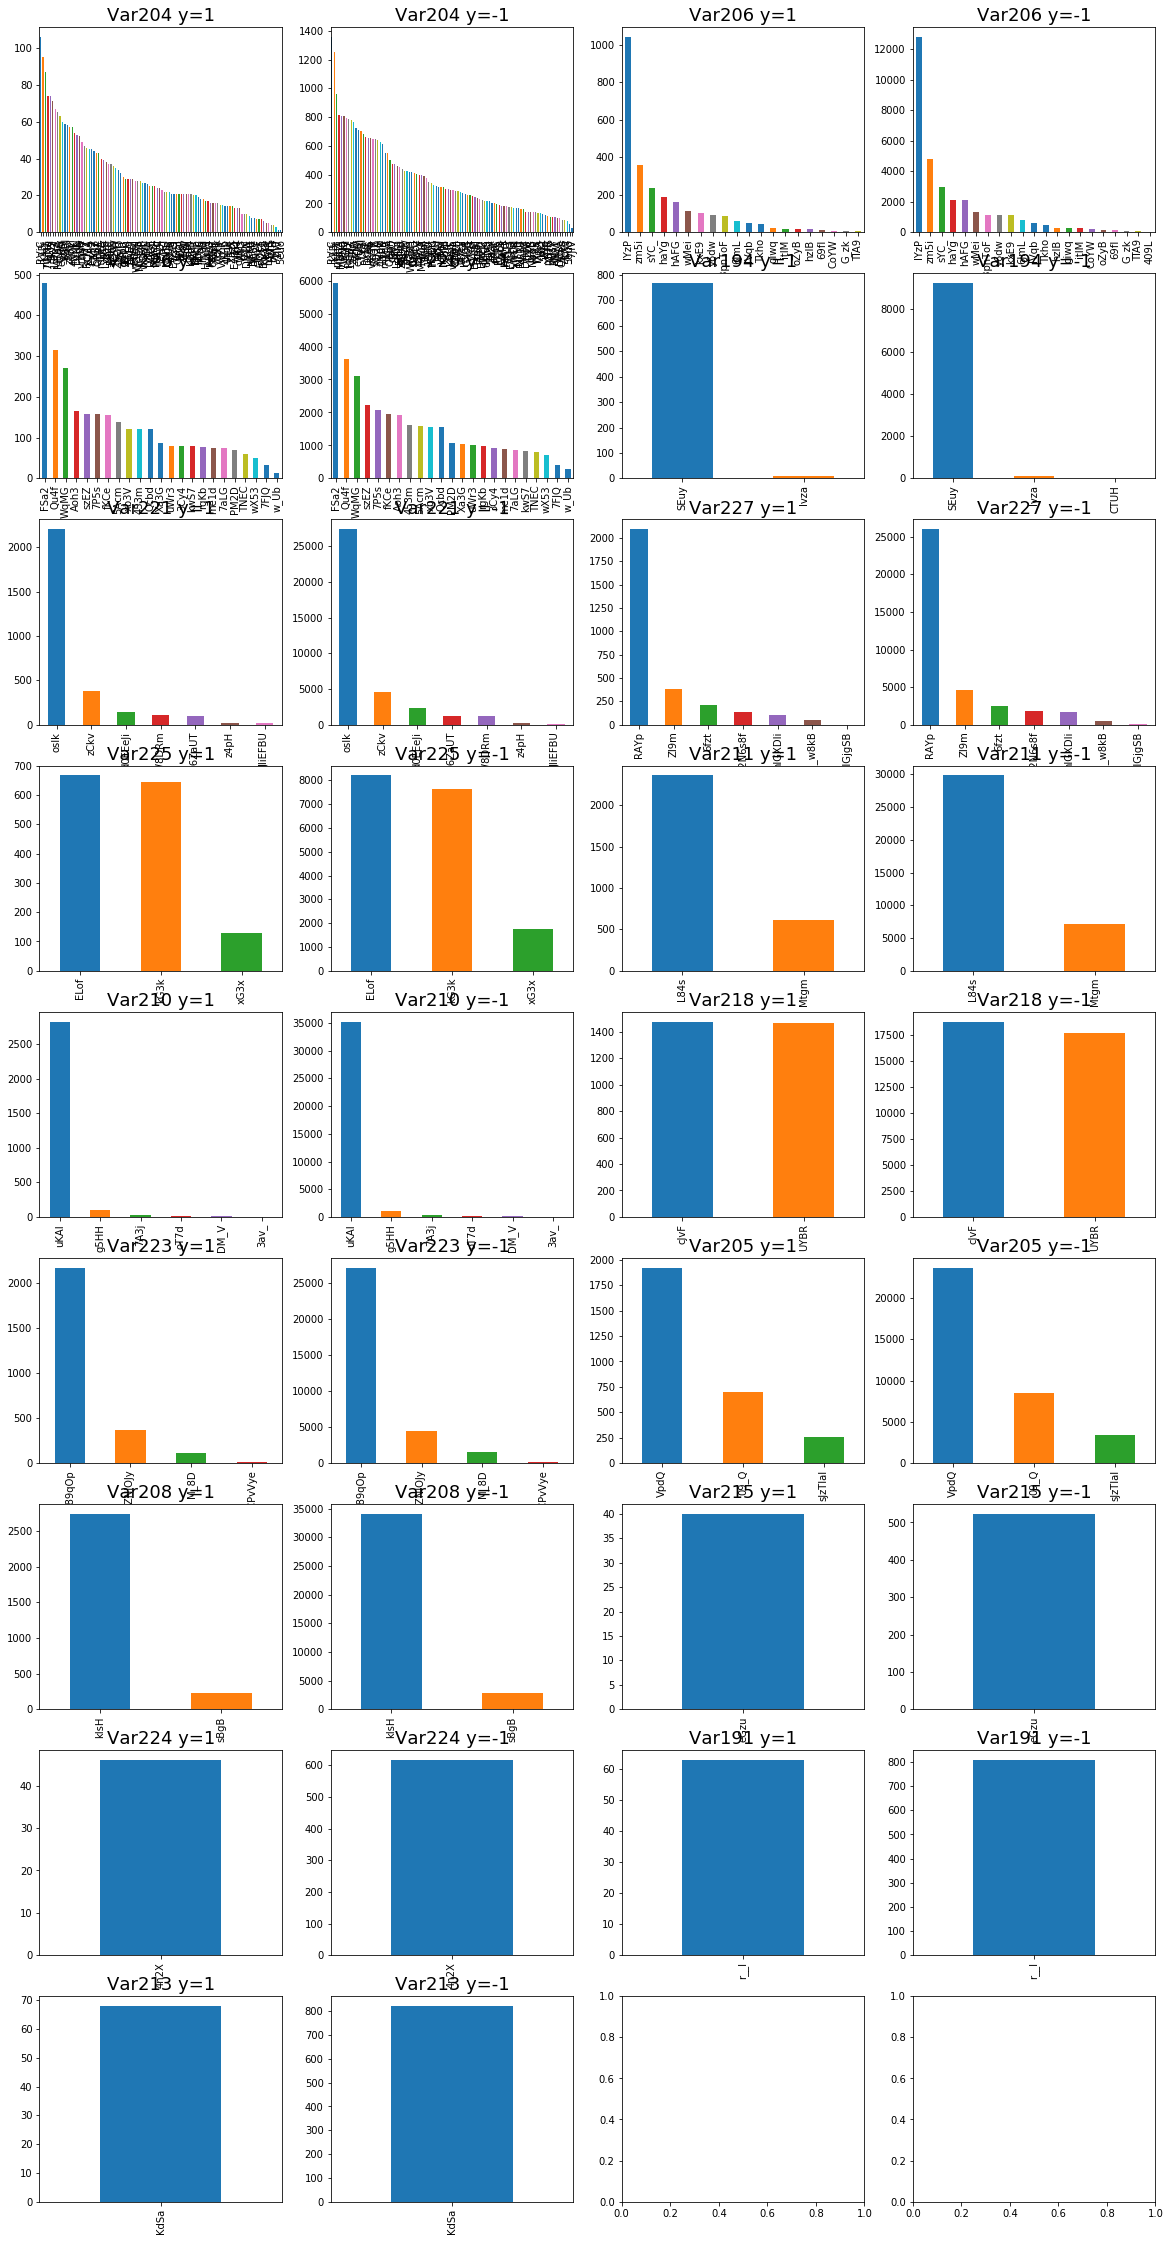

In [46]:
corr_cat = []
fig, axarr = plt.subplots(9, 4, figsize=(20, 40))
for idx,tup in enumerate(X_cat_corrs_sorted):
    axarr[2*idx/4][2*idx%4].set_title(tup[0]+' y=1', fontsize=18)
    data[data.loc[:,'y']==1].loc[:,tup[0]].value_counts().plot.bar(ax=axarr[2*idx/4][2*idx%4])
    axarr[2*idx/4][2*idx%4+1].set_title(tup[0]+' y=-1', fontsize=18)
    data[data.loc[:,'y']==-1].loc[:,tup[0]].value_counts().plot.bar(ax=axarr[2*idx/4][2*idx%4+1])
    corr_cat.append(tup[0])

<font color='green'>Затем остальные</font>

In [25]:
columns = [x for x in X.iloc[:,190:].columns if x not in corr_cat]

In [ ]:
fig, axarr = plt.subplots(11, 4, figsize=(20, 40))
idx=0
for col in columns:
    try:
        axarr[2*idx/4][2*idx%4].set_title(col+' y=1', fontsize=18)
        data[data.loc[:,'y']==1].loc[:,col].value_counts().plot.bar(ax=axarr[2*idx/4][2*idx%4])
        axarr[2*idx/4][2*idx%4+1].set_title(col+' y=-1', fontsize=18)
        data[data.loc[:,'y']==-1].loc[:,col].value_counts().plot.bar(ax=axarr[2*idx/4][2*idx%4+1])
        idx+=1
    except:
        pass

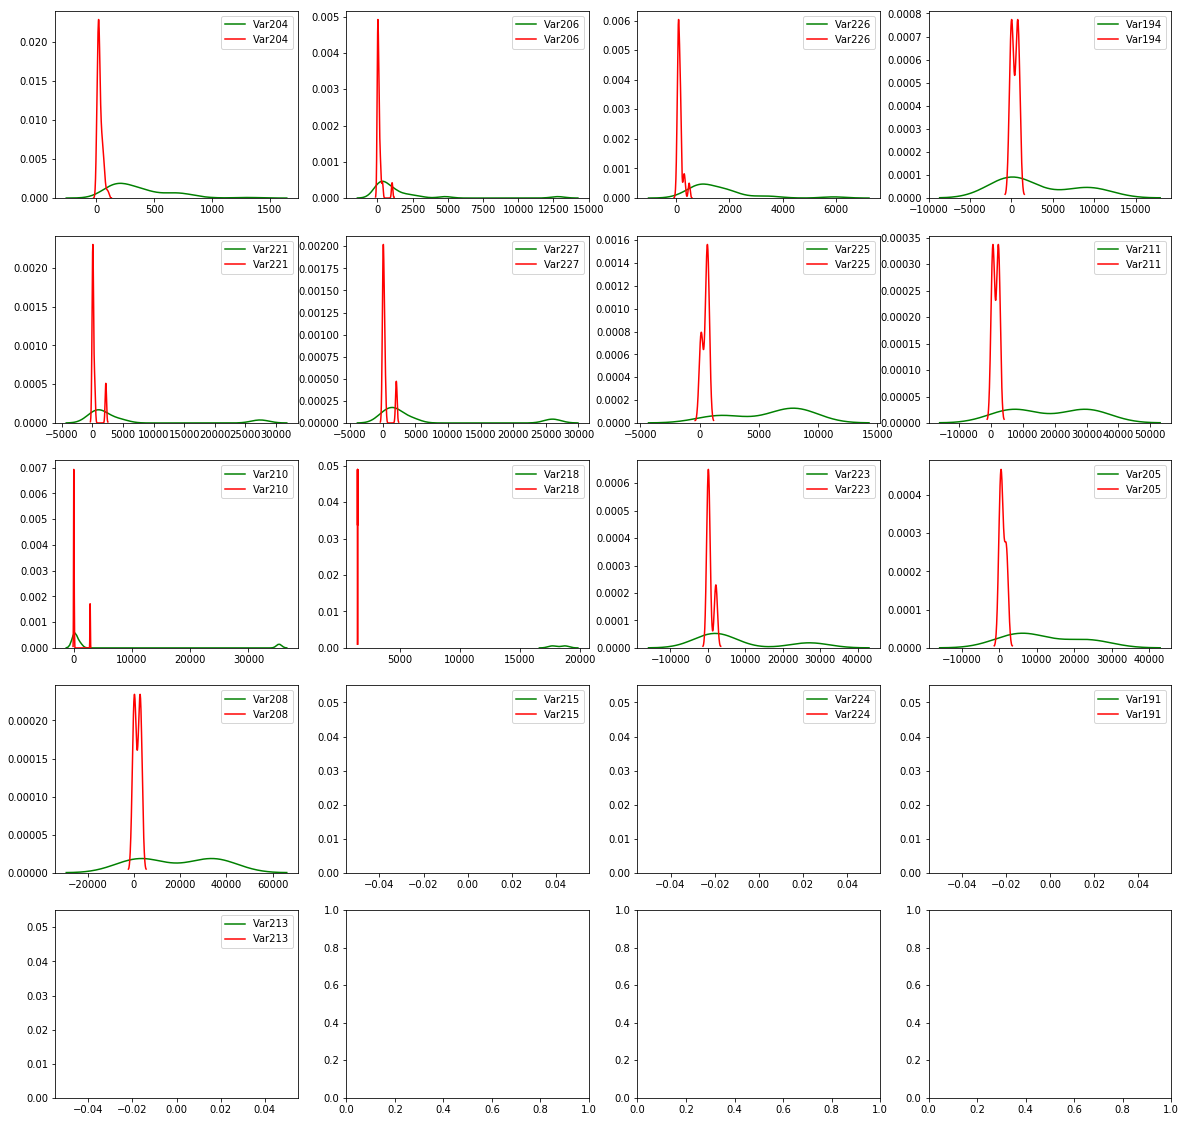

In [48]:
fig3, axarr3 = plt.subplots(5,4,figsize=(20,20))
for idx,col in enumerate(corr_cat):
    sns.kdeplot(data[data.y==-1].loc[:,col].value_counts(),ax=axarr3[idx/4][idx%4], color='green')
    sns.kdeplot(data[data.y==1].loc[:,col].value_counts(),ax=axarr3[idx/4][idx%4], color='red')


8\. Проанализируйте полученные результаты:
* Какие выводы вы можете сделать? Заметили ли вы какие-нибудь интересные закономерности?
* На основании полученных изображений и таблиц, предположите, какие переменные окажут наибольшее влияние (вклад) в модель?
* Какие переменные на ваш взгляд окажутся наименее полезными, шумовыми?
* Как вы думаете, окажется ли отбор признаков полезным для построения модели?

<font color='green'>Плотности распределения признаков Var100, Var92 и Var186 наиболее отличаются в зависимости от класса. Распределение объектов в координатах Var45 и Var92 имеет сильно разную закономерность зависимо от класса. Среди произвольно выбраных числовых параметров есть практически линейные зависимости. Например, Var22-Var123 и Var22-Var160</font>

<font color='green'>Для категориальных же признаков плотность распределения ведет себя странно, кардинально отличается для разных классов, Хотя barchart показывает, что оно на самом деле примерно равномерное</font>

<font color='green'>Lightgbm модель построенная выше показывает на неочевидность отбора значимости признаков при обучении. Большинство из топ-20 числовых в нее не попали. Вобщем нахожу затруднительным интерпретировать графики и определять значимые переменные, кроме трех числовых, которые называл в начале</font>

почему-то не грузится работа, пробую увеличить ее вес картинкой
<img src="r1.jpg">